# Transfer learning with TensorFlow part 1: feature extraction

Transfer learning is laveraging a working models existing architecture and learned pattern for our own problem.

There are two main benefits:
1. can laverage an existing a neural network architecture proven to work on problem similar to our own.
2. Can laverage a working neural network architecture which already learned patterns on similar data to our own, then we can adapt those pattern to our own data.

In [7]:
# Get data (10% of 10 food classes from food 101)
import zipfile
import wget

# Download the data
wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip")
    

  0% [                                                                      ]    688128 / 168546183

  0% [                                                                      ]   1646592 / 168546183

  1% [.                                                                     ]   3276800 / 168546183

  2% [.                                                                     ]   4194304 / 168546183

100% [......................................................................] 168546183 / 168546183

'10_food_classes_10_percent.zip'

In [8]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [12]:
# How many images in each folder ?
import os

# Walk through 10 percent data directory and list number of list
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent.zip"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [30]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical"
                                                         )
print("Testing images: ")
test_data = test_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical"
                                                       )

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 750 images belonging to 10 classes.


## Setting up the callback (things to run whilst our model trains)

Callbacks are extra functionality you can add to our models to be performed during or after trining. Some of the most popular callbacks:

* Tracking the experiment with the tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains to long and overfitting) with the EarlyStopping callback

In [40]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to : {log_dir}")
    return tensorboard_callback

**Note:** you can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

# Creating model with TensorFlow Hub

In the past we've used TensorFlow to create own models layer by layer from scratch.

Now we're going to do similar process, except the majority of our model's layer are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [41]:
# Lets compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [42]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [43]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [44]:
# Lets make a created_model() function to create a model from URL

def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    
    Args:
    model_url (str): A TensorFlow Hub feature extraction url.
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.
    
    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
    """
    
    # Download the pretrained model and save it as a Keras laer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # Freeze the already learned patterns
                                             name="featur_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    
    return model
    

# Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [45]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes
                           )

In [46]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
featur_extraction_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [47]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"]
                    )

In [49]:
# Lets fit our ResNet to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(train_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2"
                                                                        )]
                                 )

Saving TensorBoard log file to : tensorflow_hub/resnet50v2/20220224-175436
Epoch 1/5
 1/24 [>.............................] - ETA: 0s - loss: 2.8724 - accuracy: 0.1875WARNING:tensorflow:From C:\Users\320044942\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


24/24 [==============================] - 9s 360ms/step - loss: 1.9241 - accuracy: 0.3640 - val_loss: 1.0761 - val_accuracy: 0.6853
Epoch 2/5
24/24 [==============================] - 6s 260ms/step - loss: 0.8929 - accuracy: 0.7427 - val_loss: 0.6740 - val_accuracy: 0.8080
Epoch 3/5
24/24 [==============================] - 6s 260ms/step - loss: 0.6137 - accuracy: 0.8120 - val_loss: 0.4969 - val_accuracy: 0.8693
Epoch 4/5
24/24 [==============================] - 6s 260ms/step - loss: 0.4795 - accuracy: 0.8747 - val_loss: 0.3953 - val_accuracy: 0.9040
Epoch 5/5
24/24 [==============================] - 6s 259ms/step - loss: 0.3785 - accuracy: 0.9173 - val_loss: 0.3223 - val_accuracy: 0.9427


Wow!

That's incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples

In [51]:
# Lets create a function to plot our loss curves...
# Tidbit: you could put a function like this into a scrpit called "helper.py" and import it when you need it...

import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    
    Args:
        hitory: TensorFlow History object.
        
    Returns:
        Plots of training/validation loss and accuracy metrics
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

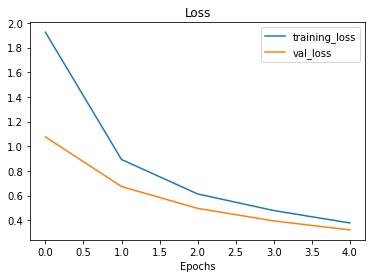

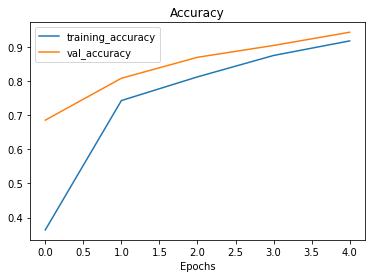

In [52]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Fetaure Extraction model

In [54]:
# Create EfficientB0 fetaure extractor model --> details on EfficientNetB0 : https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")]
                                             )

Saving TensorBoard log file to : tensorflow_hub/efficientnetb0/20220224-194151
Epoch 1/5
 2/24 [=>............................] - ETA: 7s - loss: 2.3127 - accuracy: 0.1719WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1073s vs `on_train_batch_end` time: 0.5437s). Check your callbacks.


24/24 [==============================] - 7s 289ms/step - loss: 1.8618 - accuracy: 0.4133 - val_loss: 1.2837 - val_accuracy: 0.7307
Epoch 2/5
24/24 [==============================] - 5s 202ms/step - loss: 1.0659 - accuracy: 0.7693 - val_loss: 0.8468 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 5s 203ms/step - loss: 0.7650 - accuracy: 0.8160 - val_loss: 0.6547 - val_accuracy: 0.8467
Epoch 4/5
24/24 [==============================] - 5s 200ms/step - loss: 0.6146 - accuracy: 0.8533 - val_loss: 0.5438 - val_accuracy: 0.8733
Epoch 5/5
24/24 [==============================] - 5s 200ms/step - loss: 0.5185 - accuracy: 0.8760 - val_loss: 0.4661 - val_accuracy: 0.9013


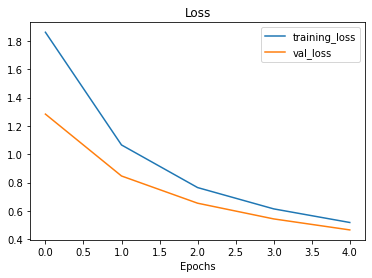

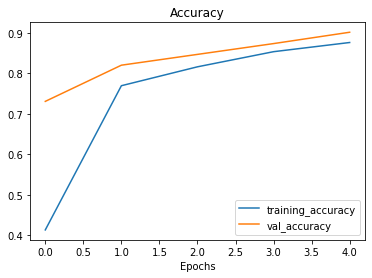

In [55]:
# Lets plot the model loss curves
plot_loss_curves(efficientnet_history)

In [56]:
# Lets check the model layers summary
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
featur_extraction_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [57]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
featur_extraction_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [60]:
# How many layers does our efficientnetb0 feature extractor have ?
len(efficientnet_model.layers[0].weights)
#efficientnet_model.layers[0].weights

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust otput layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

>**Note:** When you upload things to TensorBoard .dev, you experiments (things you don't want to others to see) do not upload them to tensorboard.dev.

In [67]:
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp

In [64]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" --one_shot

^C


In [66]:
# Check out what TensorBoard experiments you have
!tensorboard dev list 

^C


In [63]:
# Delete an experiment
#!tensorboard dev delete --experiment_id 

In [65]:
# Confirm the deletion by re-checking what experiment you have left
!tensorboard dev list

^C
